# 3D *tobac* Tutorial: Gridded Radar Data

This tutorial will demonstrate how to use *tobac* to detect and track convection with gridded radar data. Because this tutorial uses 3D feature detection, you must use the v1.5 beta (3D and PBC changes) of *tobac*. 

In [1]:
%matplotlib inline

Note that this tutorial also requires Py-ART to grid the radar data.

#### Imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import pyart
import glob
import datetime
import matplotlib.gridspec as gridspec
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead


### Load and Preprocess Data

In [5]:
# Read the data that is in antenna coordinates for all radars
all_radar_data = dict()
for radar_file_name in sorted(glob.glob("./radar_data/KCYS20170525*")):
    radar_time_str = radar_file_name.split('/')[-1][4:-4]
    radar_time = datetime.datetime.strptime(radar_time_str, '%Y%m%d_%H%M%S')
    all_radar_data[radar_time] = pyart.io.read(radar_file_name)


*tobac* is designed to work with **gridded** data currently, so we must first grid the radial radar data. This is a quick and dirty gridding, but it will get the job done for this tutorial. Much better gridding results could be had with tuning of the parameters.

In [6]:
all_radar_gridded = dict()
for radar_time in all_radar_data:
    all_radar_gridded[radar_time] = pyart.map.grid_from_radars(all_radar_data[radar_time], grid_shape=(41, 401, 401),
                                  grid_limits=((0.,20000,), (-200000., 200000.), (-200000, 200000.)))


In [7]:
all_times = list(all_radar_gridded)

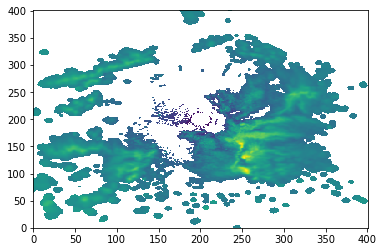

In [8]:
plt.pcolormesh(all_radar_gridded[all_times[3]].to_xarray()['reflectivity'][0,6])

In [9]:
# Setting projection and ploting the second tilt
proj = ccrs.PlateCarree()


In [10]:
all_xr_grids = list()
for radar_time in all_radar_gridded:
    all_xr_grids.append(all_radar_gridded[radar_time].to_xarray())

In [11]:
all_xr_data = xr.concat(all_xr_grids, 'time')

In [12]:
all_xr_data.to_netcdf("./radar_data/all-data-gridded.nc")

In [13]:
all_xr_data = xr.open_dataset("./radar_data/all-data-gridded.nc")

/Users/sfreeman/miniconda3/envs/tobac_15/lib/python3.10/site-packages/xarray/backends/plugins.py:98: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  entrypoints = entry_points().get("xarray.backends", ())


Load in *tobac*

In [15]:
import tobac
import tobac.testing
import tobac.feature_detection
import tobac.segmentation

In [16]:
feature_detection_params = dict()
feature_detection_params['threshold'] = [30, 40, 50]
feature_detection_params['target'] = 'maximum'
feature_detection_params['position_threshold'] = 'weighted_diff'
feature_detection_params['n_erosion_threshold'] = 2
feature_detection_params['sigma_threshold'] = 1
feature_detection_params['n_min_threshold'] = 4


Note that to track in 3D, we must give information about what our height coordinate is. Iris tends to be picky about the naming conventions, so we need to assign standard names as well.

In [17]:
xr_grid_full = all_xr_data['reflectivity']
xr_grid_full['z'] = xr_grid_full.z.assign_attrs({'standard_name': 'altitude'})
xr_grid_full['lat'] = xr_grid_full.lat.assign_attrs({'standard_name': 'latitude'})
xr_grid_full['lon'] = xr_grid_full.lon.assign_attrs({'standard_name': 'longitude'})

In [18]:
grid_iris = xr_grid_full.to_iris()


In [19]:
out_fd = tobac.feature_detection_multithreshold(grid_iris, 0, **feature_detection_params)

/Users/sfreeman/miniconda3/envs/tobac_15/lib/python3.10/site-packages/tobac/feature_detection.py:818: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter
/Users/sfreeman/miniconda3/envs/tobac_15/lib/python3.10/site-packages/tobac/feature_detection.py:847: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  features_thresholds = features_thresholds.append(features_threshold_i)
/Users/sfreeman/miniconda3/envs/tobac_15/lib/python3.10/site-packages/tobac/feature_detection.py:818: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter
/Users/sfreeman/miniconda3/envs/tobac_15/lib/python3.10/site-packages/tobac/feature_detection.py:847: Future

In [20]:
out_fd

,frame,idx,vdim,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,altitude,projection_y_coordinate,projection_x_coordinate,latitude,longitude
0,0,1,7.068803,101.211213,243.209585,604,30,1,2017-05-25 17:26:49,2017-05-25 17:26:49,3534.401549,-98788.787273,43209.585379,40.239296,-104.303573
1,0,2,6.323391,128.182902,246.309060,77,30,2,2017-05-25 17:26:49,2017-05-25 17:26:49,3161.695734,-71817.098037,46309.059682,40.481731,-104.267532
2,0,3,3.777254,151.520583,242.152049,464,30,3,2017-05-25 17:26:49,2017-05-25 17:26:49,1888.626823,-48479.416521,42152.049269,40.691501,-104.315870
3,0,4,3.076199,166.613288,250.911352,26,30,4,2017-05-25 17:26:49,2017-05-25 17:26:49,1538.099446,-33386.712403,50911.352289,40.827161,-104.214017
4,1,1,7.888155,102.701610,247.217079,684,30,5,2017-05-25 17:31:09,2017-05-25 17:31:09,3944.077652,-97298.390012,47217.078515,40.252693,-104.256974
5,1,2,4.419903,128.993949,247.956499,197,30,6,2017-05-25 17:31:09,2017-05-25 17:31:09,2209.951326,-71006.050519,47956.498951,40.489021,-104.248376
6,1,3,4.071411,154.854719,246.461700,907,30,7,2017-05-25 17:31:09,2017-05-25 17:31:09,2035.705625,-45145.280940,46461.700166,40.721470,-104.265757
7,1,4,2.751201,179.108779,245.680610,9,30,8,2017-05-25 17:31:09,2017-05-25 17:31:09,1375.600341,-20891.220878,45680.610335,40.939476,-104.274840
8,2,1,8.136221,104.295785,251.222258,693,30,9,2017-05-25 17:35:29,2017-05-25 17:35:29,4068.110442,-95704.215097,51222.258374,40.267022,-104.210402
9,2,2,6.191406,129.904229,251.221589,311,30,10,2017-05-25 17:35:29,2017-05-25 17:35:29,3095.702992,-70095.771355,51221.588984,40.497203,-104.210409


In [21]:
out_tracking = tobac.linking_trackpy(out_fd, None, 300, dxy = 2000, v_max=30)

Frame 3: 5 trajectories present.


In [22]:
cell_2_out = out_tracking[out_tracking['cell']==2]

In [23]:
cell_2_out

,frame,idx,vdim,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,altitude,projection_y_coordinate,projection_x_coordinate,latitude,longitude,cell,time_cell
1,0,2,6.323391,128.182902,246.309060,77,30,2,2017-05-25 17:26:49,2017-05-25 17:26:49,3161.695734,-71817.098037,46309.059682,40.481731,-104.267532,2,0 days 00:00:00
5,1,2,4.419903,128.993949,247.956499,197,30,6,2017-05-25 17:31:09,2017-05-25 17:31:09,2209.951326,-71006.050519,47956.498951,40.489021,-104.248376,2,0 days 00:04:20
9,2,2,6.191406,129.904229,251.221589,311,30,10,2017-05-25 17:35:29,2017-05-25 17:35:29,3095.702992,-70095.771355,51221.588984,40.497203,-104.210409,2,0 days 00:08:40
14,3,2,6.772883,130.859072,254.270990,553,30,15,2017-05-25 17:39:34,2017-05-25 17:39:34,3386.441701,-69140.928243,54270.989694,40.505786,-104.174951,2,0 days 00:12:45


In [24]:
def round_seconds(obj: datetime.datetime) -> datetime.datetime:
    if obj.microsecond >= 500_000:
        obj += datetime.timedelta(seconds=1)
    return obj.replace(microsecond=0)


In [25]:
fig = plt.figure(figsize=[16, 6])
spec = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)
all_ax = list()
x_range = 15
for i, radar_time in enumerate(all_xr_data.time):
    pydt_radar = datetime.datetime.strptime(str(radar_time.values),'%Y-%m-%d %H:%M:%S.%f')
    pydt_radar = round_seconds(pydt_radar)

    ax = fig.add_subplot(spec[0,i], projection=ccrs.PlateCarree())
    all_ax.append(ax)
    curr_xr_data = all_xr_data.sel(time=radar_time)
    ax.set_extent([-104.35, -104.1, 40.35, 40.6], crs=ccrs.PlateCarree())

    cm = ax.pcolormesh(all_xr_data['lon'], all_xr_data['lat'], curr_xr_data['reflectivity'][4], vmin=-30, vmax=95, 
                    transform=ccrs.PlateCarree(), cmap = 'wdtbtable')

    states_provinces = cfeature.NaturalEarthFeature(category='cultural',
    name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    ax.add_feature(states_provinces, edgecolor='gray')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'fontsize':14}
    gl.ylabel_style = {'fontsize': 14}
    
    #cb = plt.colorbar(cm)
    #cb.set_label("Reflectivity (dBZ)", size=14)
    #cb.ax.tick_params(labelsize=14)
    plt.title("2 km AGL, "+pydt_radar.strftime("%H:%MZ"), size=14)
    #pydt_radar = pydt_radar.replace(microsecond=round(pydt_radar.microsecond, -3))
    curr_time_cell = cell_2_out[cell_2_out['time']==pydt_radar]
    past_time_cell = cell_2_out[cell_2_out['time']<=pydt_radar]
    min_x_pt = round(curr_time_cell['hdim_2'].values[0])-x_range
    max_x_pt = round(curr_time_cell['hdim_2'].values[0])+x_range
    curr_y_pt = round(curr_time_cell['hdim_1'].values[0])

    ax.scatter(curr_time_cell['longitude'], curr_time_cell['latitude'], 30, transform=ccrs.PlateCarree(), color='r')
    ax.plot(past_time_cell['longitude'].values, past_time_cell['latitude'].values, color='r', transform=ccrs.PlateCarree())
    ax.plot([all_xr_data['lon'][min_x_pt], all_xr_data['lon'][max_x_pt]], [all_xr_data['lat'][curr_y_pt], all_xr_data['lat'][curr_y_pt]], color='k', ls=':',
                transform=ccrs.PlateCarree())
    #plt.savefig("./radar_example_2/base_ref_202105261556_withfeatures.png", facecolor='w', bbox_inches='tight')
spec = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)
for i, radar_time in enumerate(all_xr_data.time):
    ax = fig.add_subplot(spec[1,i])
    all_ax.append(ax)
    pydt_radar = datetime.datetime.strptime(str(radar_time.values),'%Y-%m-%d %H:%M:%S.%f')
    pydt_radar = round_seconds(pydt_radar)
    curr_xr_data = all_xr_data.sel(time=radar_time)
    curr_time_cell = cell_2_out[cell_2_out['time']==pydt_radar]
    curr_y_pt = round(curr_time_cell['hdim_1'].values[0])
    min_x_pt = round(curr_time_cell['hdim_2'].values[0])-x_range
    max_x_pt = round(curr_time_cell['hdim_2'].values[0])+x_range
    min_z_pt = 1
    max_z_pt = 37
    cm = ax.pcolormesh(all_xr_data['lon'][min_x_pt:max_x_pt], (all_xr_data['z']/1000)[min_z_pt:max_z_pt], 
        curr_xr_data['reflectivity'][min_z_pt:max_z_pt, curr_y_pt, min_x_pt:max_x_pt], cmap = 'wdtbtable',  vmin=-30, vmax=95,)
    past_time_cell = cell_2_out[cell_2_out['time']<=pydt_radar]

    ax.scatter(curr_time_cell['longitude'], curr_time_cell['altitude']/1000, 30, color='r')
    ax.plot(past_time_cell['longitude'].values, past_time_cell['altitude'].values/1000, color='r')
    ax.tick_params(labelsize=14)
    lon_formatter = LongitudeFormatter(number_format='.1f',
                                       dateline_direction_label=True)
    ax.xaxis.set_major_formatter(lon_formatter)
    if i == 0:
        ax.set_ylabel("Altitude (km)", size=14)

    

label_prefix = ''
label_suffix = ')'
for ax, label in zip(all_ax, 'abcdefghijklmno'):
    ax.text(-0.1,1.02, label_prefix+label+label_suffix, transform=ax.transAxes, size=18)

#plt.savefig("3D_track_example.png", dpi=300)

ValueError: time data '2017-05-25T17:26:49.098000000' does not match format '%Y-%m-%d %H:%M:%S.%f'

<Figure size 1152x432 with 0 Axes>